# Training 
# of pre-trained U-shape Resnet50 
# for semantic SEGMENTATION



------------
---------
## Preparation
----

In [ ]:
!pip install keras-utils -q
!pip install preprocessing -q
!pip install keras -q
!pip install d2l==0.17.5 -q
!pip install -U mxnet-cu101==1.7.0 -q
!pip install keras-applications -q
!pip install pickle -q
!pip install matplotlib==3.1.1 -q

In [347]:
%matplotlib
import gc
import os
import numpy as np
import tensorflow as tf
import os, sys
from PIL import Image
from matplotlib import pyplot as plt
import pickle

Using matplotlib backend: agg


Training on Google Colab mounted on Gdrive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading pretrained model
----
Pretained model: U-ResNet50

Shape in- & output: 512x512 not adopted

In [56]:
"""
These functions import the pre-trained resnet and build the model.
"""

#----------------------IMPORTS---------------------------#

import tensorflow as tf
from keras.layers import *
from keras.models import Model
from tensorflow.keras.applications import ResNet50

#------------------------FUNCTIONS-----------------------#

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_resnet50_unet(input_shape, input_dim):
    """input"""
    inputs = Input(input_shape)

    """Pre-trained ResNet50"""
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    """Encoder"""
    # shapes:s
    s1 = resnet.get_layer('input_1').output             ## input_dim
    s2 = resnet.get_layer('conv1_relu').output          ## 256
    s3 = resnet.get_layer('conv2_block3_out').output    ## 128
    s4 = resnet.get_layer('conv3_block4_out').output    ## 64

    """Bridge"""
    b1 = resnet.get_layer('conv4_block6_out').output    ## 32

    """Decoder"""
    d1 = decoder_block(b1, s4, input_dim)                     ## 64
    d2 = decoder_block(d1, s3, input_dim)                     ## 128
    d3 = decoder_block(d2, s2, input_dim)                     ## 256
    d4 = decoder_block(d3, s1, input_dim)                     ## input_dim

    """Output"""
    ## check this with a breakpoint
    outputs = Conv2D(4, 1, padding='same', activation='softmax')(d4)    ## changed from 1 to 4 channels

    model = Model(inputs, outputs)
    return model


#------------------------EXECUTION-----------------------#

if __name__ == "__main__":
    input_dim = 512
    path = "drive/MyDrive/urbaneagle/models/orig_resnet"

    input_shape = (input_dim, input_dim, 3)
    model_orig = build_resnet50_unet(input_shape, input_dim)
    model_orig.summary()
    model_orig.save(f'{path}')
    print(f"Model saved at {path}")

    tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Data pipeline
----


Load the annotation mask ("y") for supervised training:

Mask imported: (2427, 4800, 4).
class distribution: [0.20065538730943552, 0.2913886313693174, 0.12676460994368904, 0.38119137137755804]


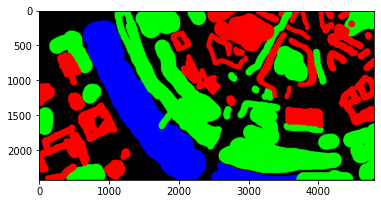

In [348]:
mask = np.array((np.load("gdrive/MyDrive/urbaneagle/input/Dresden_01/mask.npy")))
print(f"Mask imported: {mask.shape}.\n"
      f"class distribution: {[np.sum(mask[: , :, i]) / mask[:, :, 0].size for i in range(4)]}")
img_mask = mask[:, :, :3]
plt.imshow(img_mask)
plt.show()

Preprocessing pipeline:
1) split the image in equally-shaped tiles
2) label the tiles with according mask tile
3) make dataset for training

In [27]:

def make_tiles(
        x, image, mask, target, i_width, i_height, tile_size):

    # prepare variables for both tile layers
    ## rounded down to full tiles ignoring the last tile if it is not full:
    num_hor = int(i_width // tile_size)
    num_ver = int(i_height // tile_size)
    num_tiles = num_hor * num_ver
    print(  f"Slicing image {target}\n"
            f"   There are {num_tiles} small tiles at {tile_size}x{tile_size} pixels\n"
            f"   Small tiles identified: {num_ver} X {num_hor} tiles")

    # prepare variables for the tiles
    image = np.array(image) # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
    masks = np.zeros((num_tiles, tile_size, tile_size, 4)) # all tile masks

    # initiate info variables
    ## store information about the tiles in total and in each layer:
    tile_dims = (num_tiles, num_ver, num_hor)
    tile_info = np.zeros((num_tiles, 5)) # store information about the tiles
    ## tile_info:
        ### [0:2] image_number, tile row, tile column,
        ### [3:4] position horizontal, position vertical  // (top left corner of tile in the image)

    # create tiles and masks for target image
    for i in range(num_ver):
        for j in range(num_hor):
            tile_num = i * num_hor + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = i * tile_size
            h_start = j * tile_size
            # create tile
            tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            mask_tile = mask[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            # add to array
            tiles[tile_num] = tile
            masks[tile_num] = mask_tile
            # store location ot tiles:
            tile_info[tile_num] = (x, i, j, v_start, h_start)

    print(f"   Tiles created: {tiles.shape}.\n")
    print(f"   Masks created: {masks.shape}.\n")

    return tiles, masks, tile_info, tile_dims


def image_mask_load(
        path_input, target, x, tile_size):

    # load image and mask
    image = tf.keras.preprocessing.image.load_img(path_input + target + "/" + target + '.jpg')
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype('float32')
    i_height, i_width, channels = image.shape
    image /= 255.0

    mask = np.load(path_input + target + "/mask.npy")
    print(f"Mask imported: {mask.shape}.\n"
          f"class distribution: {[np.sum(mask[: , :, i]) / mask[:, :, 0].size for i in range(4)]}")

    print(f"\nInput Images: {target}\n"
          f"image.shape: {image.shape}\n"
          f"masks.shape: {mask.shape}\n")

    # SLICE to tiles
    x_tiles, x_masks, x_tile_info, x_dims = \
        make_tiles(
            x, image, mask, target, i_width, i_height, tile_size)

    del mask, image
    gc.collect()

    return x_tiles, x_masks, x_tile_info, x_dims


def make_train_set(
        tiles, masks, tile_size, batch_size):

    # define the training set
    train_ratio = 0.8
    num_tiles = tiles.shape[0]
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"There are {num_tiles} tiles in total.")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_masks = masks[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_masks = masks[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_masks))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_masks))

    # shuffle and batch
    def encode(tile, mask):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, mask

    dataset_train = dataset_train_original.map(
        lambda image, label: encode(image, label)).cache().shuffle(2500).batch(batch_size)
    dataset_validate = dataset_validate_original.map(
        lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train, dataset_validate


def seg_train_load(
        path_input, targets,
        tile_size, batch_size, path_model):

    # make the model_name directory
    if not os.path.exists(f"{path_model}"):
        os.mkdir(f"{path_model}")


    #----------------IMAGE-LOOP----------------------#

    for x in range(len(targets)):

        # LOAD image and labels
        x_tiles, x_masks, x_tile_info, x_dims = \
            image_mask_load(
                path_input, targets[x], x, tile_size)

        # concat data of image x
        if x == 0:
            tiles = x_tiles
            masks = x_masks
            tile_info = x_tile_info
            dims = x_dims
        else:
            tiles = np.concatenate((tiles, x_tiles), axis=0)
            masks = np.concatenate((masks, x_masks), axis=0)
            tile_info = np.concatenate((tile_info, x_tile_info), axis=0)
            dims = np.concatenate((dims, x_dims), axis=0)

    del x_tiles, x_masks, x_tile_info, x_dims
    gc.collect()

    # ----------------TRAINING SET------------------#

    # Make dataset
    dataset_train, dataset_validate = \
        make_train_set(
            tiles, masks, tile_size, batch_size)

    del masks
    gc.collect()

    return tiles, dataset_train, dataset_validate, tile_info, dims


def pred_load(
        image_path, tile_size, name):

    image = tf.keras.preprocessing.image.load_img(image_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype('float32')
    i_height, i_width, channels = image.shape
    image /= 255.0

    # SLICE to tiles
    # rounded down to full tiles ignoring the last tile if it is not full:
    num_hor = int(i_width // tile_size)
    num_ver = int(i_height // tile_size)
    num_tiles = num_hor * num_ver
    dims = [num_tiles, num_ver, num_hor]
    print(f"Slicing image {name}\n"
          f"   There are {num_tiles} small tiles at {tile_size}x{tile_size} pixels\n"
          f"   Small tiles identified: {num_ver} X {num_hor} tiles")

    # prepare variables for the tiles
    image = np.array(image)  # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3))  # all tile images

    # create tiles and masks for target image
    for i in range(num_ver):
        for j in range(num_hor):
            tile_num = i * num_hor + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = i * tile_size
            h_start = j * tile_size
            # create tile
            tile = image[v_start:v_start + tile_size, h_start:h_start + tile_size, :]
            # add to array
            tiles[tile_num] = tile

    print(f"   Tiles created: {tiles.shape}.\n")

    return image, tiles, dims

## Training
## (finetuning of segmentation model)
-----


--------------------------------------------
Start training of SEGMENTATION MODEL!
Mask imported: (2427, 4800, 4).
class distribution: [0.20065538730943552, 0.2913886313693174, 0.12676460994368904, 0.38119137137755804]

Input Images: Dresden_01
image.shape: (2427, 4800, 3)
masks.shape: (2427, 4800, 4)

Slicing image Dresden_01
   There are 36 small tiles at 512x512 pixels
   Small tiles identified: 4 X 9 tiles
   Tiles created: (36, 512, 512, 3).

   Masks created: (36, 512, 512, 4).

There are 36 tiles in total.
There are 28 tiles in the training set.
There are 8 tiles in the validation set.
Training set: (28, 512, 512, 3) - (0.8 share of all tiles)
Validation set: (8, 512, 512, 3)

--------------------------------------------
Start training of U-RNN...
Epoch 1/200
14/14 [==============================] - 71s 5s/step - loss: 2.0163 - categorical_crossentropy: 0.7331 - F1Score: 0.0813 - categorical_accuracy: 0.0813 - precision: 0.3533 - accuracy: 0.3533 - TruePositives: 0.0813 - TrueN

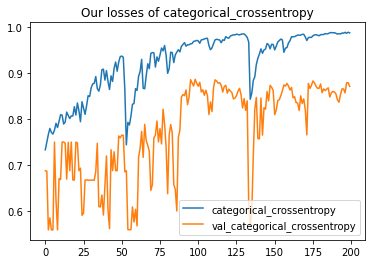

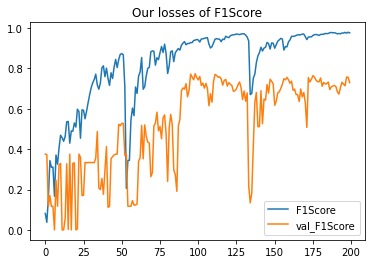

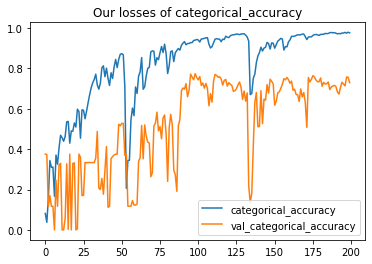

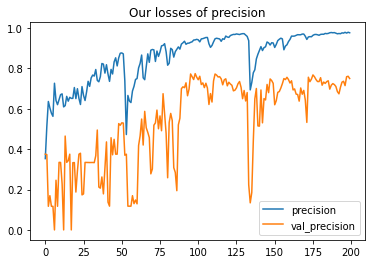

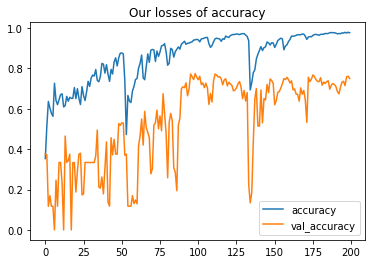

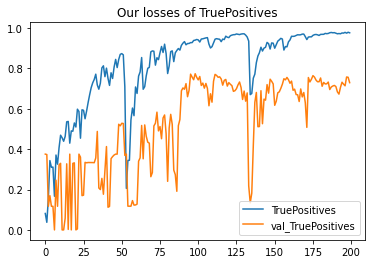

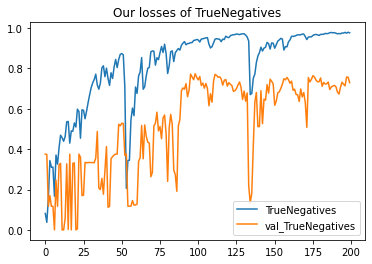

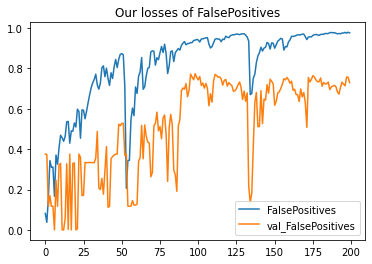

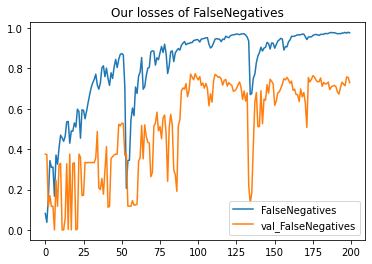


---------------------------------------------------------------
Training of SEGMENTATION MODEL ended!


In [58]:

# ------------INITIALIZATION----  CHANGE ME  -------#

# Input specification:
# targets: Name of specific image:
targets = (["Dresden_01"])
path_input = 'gdrive/MyDrive/urbaneagle/input/'

# Define tiles (quadrants) to be used for training:
tile_size = 512

# Model specification:
path_model = 'gdrive/MyDrive/urbaneagle/models/'
model_name = f"seg_{tile_size}_opt"
path_model = path_model + model_name + '/'
batch_size = 2
epochs = 200
path_resnet = 'gdrive/MyDrive/urbaneagle/models/orig_resnet'


# -----------------------SETUP-----------------------#

print("\n--------------------------------------------"
      "\nStart training of SEGMENTATION MODEL!")

import tensorflow as tf
import numpy as np
import os
import gc
from tqdm import tqdm


# ----------------DATA PREPARATION-----------#
tiles, dataset_train, dataset_validate, tile_info, dims =\
    seg_train_load(
        path_input, targets,
        tile_size, batch_size, path_model)

    
# ----------------TRAINING-------------------#

print("\n--------------------------------------------"
      "\nStart training of U-RNN...")

# load pre-build resnet50 unet
model = model = tf.keras.models.load_model(path_resnet)

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='categorical_crossentropy'),
      tf.keras.metrics.Recall(name='F1Score'),
      tf.keras.metrics.Recall(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Precision(name='accuracy'),
      tf.keras.metrics.Recall(name='TruePositives'),
      tf.keras.metrics.Recall(name='TrueNegatives'),
      tf.keras.metrics.Recall(name='FalsePositives'),
      tf.keras.metrics.Recall(name='FalseNegatives'),
      ]

model.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=metrics,
    )

# Model weights are saved at the end of every epoch
checkpoint_filepath = 'gdrive/MyDrive/urbaneagle/models/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1Score',
    mode='max',
    save_best_only=True)

# train model
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate,
    callbacks=[model_checkpoint_callback],
)
del dataset_train, dataset_validate
gc.collect()

# save model
model.load_weights(checkpoint_filepath)
print(f"\nModel is trained and saved as {model_name}."
      f"   You can find the model in {path_model}."
      f"---To use it for future predictions - replace default!---")
model.save(f"{path_model}")

# ----------------SELF-PREDICTION-------------#

print("\n--------------------------------------------"
      "\nRunning evaluation")


def render_history(history, path_model):
    import matplotlib.pyplot as plt
    metrics = (["categorical_crossentropy", "F1Score", "categorical_accuracy", "precision", "accuracy",
                "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
        plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
        plt.legend()
        plt.title(f"Our losses of {metric}")
        plt.show()
        plt.savefig(f"{path_model}{metric}.png")
        plt.close()
    pass

with open(path_model + 'history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
render_history(history, path_model)


# ---------------END--------------------------#
tf.keras.backend.clear_session()
print("\n---------------------------------------------------------------"
      "\nTraining of SEGMENTATION MODEL ended!")


In [ ]:
metric_list = pickle.load( open('gdrive/MyDrive/urbaneagle/models/seg_512_opt/history.pkl', "rb" ) )
metric_list

## Prediction test
----

Check model visually by aapplying it:

1) load and preprocess image
2) predict with segmentation model on image
3) concatenate output tiles back to full image & display

In [413]:

# ------------INITIALIZATION----  CHANGE ME  ----#

# info about inputs: images and labels
name = "Dresden_05"
#image_path = f'../data/raw/images_unlabeled/{name}.jpg'
image_path = f'gdrive/MyDrive/urbaneagle/input/{name}/{name}.jpg'
report_path = 'gdrive/MyDrive/urbaneagle/reports/'
report_path = report_path + name + '/'

## in pixel:
tile_size = 512

# model specification
path_model = 'gdrive/MyDrive/urbaneagle/models/'
model_name = "seg_512_opt"
path_model = path_model + model_name

# --------------------SETUP--------------------------#

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


# ----------------DATA LOADING-----------------------#
print("\n--------------------------------------------"
      f"\nLoading Image for {name}...")

image, tiles, dims = \
    pred_load(
        image_path, tile_size, name)

# ----------------------IDENTIFICATION--------------#
print("\n--------------------------------------------"
      "\nStart prediction for segmentation...")

# identify tree-tiles
model = tf.keras.models.load_model(path_model)

probabilities = ([])

for tile in tqdm(range(len(tiles))):
    prob = model.predict(np.array([tiles[tile, :, :, :]]))
    if tile == 0:
        probabilities = prob
    else: probabilities = np.concatenate((probabilities, prob), axis=0)

print(f"probs sum:{probabilities[:, :, :,:].sum()}")
print(f"count of pixels (should be equal):{dims[1] * tile_size * dims[2] * tile_size}")
probabilities.shape


--------------------------------------------
Loading Image for Dresden_05...
Slicing image Dresden_05
   There are 36 small tiles at 512x512 pixels
   Small tiles identified: 4 X 9 tiles
   Tiles created: (36, 512, 512, 3).


--------------------------------------------
Start prediction for segmentation...


100%|██████████| 36/36 [00:14<00:00,  2.52it/s]

probs sum:9437184.0
count of pixels (should be equal):9437184


(36, 512, 512, 4)

In [414]:
num_vertical = tile_size
num_horizontal = tile_size

# for tile x
x = 19 
probab = probabilities[x]
print(f"Probab: {probab.shape}")

prediction = np.zeros(probab.shape)
argmax_pred = np.argmax(probab, axis=2)

for row in tqdm(range(num_vertical)):
  for col in range(num_horizontal):
      prediction[row, col, argmax_pred[row, col].squeeze()] = 1.

## info on prediction for x
print(" ####")
print(f"# pixel: {num_vertical * num_horizontal}")
print(f"prediction {prediction.shape}: sum {prediction.sum()},  max {prediction.max()}, min {prediction.min()}")
shares = np.array([prediction[:, :, y].sum() / prediction.sum() for y in range(4)])
print(f"area type shares:{shares}")
np.save(report_path + "area_shares.npy", shares)


Probab: (512, 512, 4)


100%|██████████| 512/512 [00:00<00:00, 1994.76it/s]


 ####
# pixel: 262144
prediction (512, 512, 4): sum 262144.0,  max 1.0, min 0.0
area type shares:[0.34404373 0.13105011 0.         0.52490616]


In [415]:
num_vertical = dims[1] * tile_size
num_horizontal = dims[2] * tile_size
prob_reshaped = ([])

for row in range(dims[1]):
  # concat row-wise
  prob_row = ([])
  prob_row = np.concatenate([probabilities[(x + (row * dims[2])), :, :, :] 
                                  for x in range(dims[2])], axis=1)
  if row == 0:
    prob_reshaped = prob_row
  else:     
    prob_reshaped = np.concatenate((prob_reshaped, prob_row))

print(prob_reshaped.shape)


prediction = np.zeros(prob_reshaped.shape)
argmax_pred = np.argmax(prob_reshaped, axis=2)

for row in tqdm(range(num_vertical)):
  for col in range(num_horizontal):
      prediction[row, col, argmax_pred[row, col]] = 1.

np.save(report_path + "prediction.npy", prediction)
prediction.shape

(2048, 4608, 4)


100%|██████████| 2048/2048 [00:04<00:00, 466.22it/s]


(2048, 4608, 4)

pred sum:9437184.0
count of pixels (should be equal):9437184
area type shares:[0.10954878 0.35303571 0.1155529 ]
New shape of prediction: (2048, 4608, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


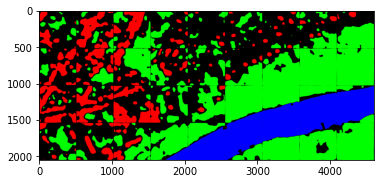

In [416]:
print(f"pred sum:{prediction.sum()}")
print(f"count of pixels (should be equal):{dims[1] * tile_size * dims[2] * tile_size}")

shares = np.array([prediction[:, :, x].sum() / prediction.sum() for x in range(3)])
print(f"area type shares:{shares}")
np.save(report_path + "area_shares.npy", shares)

prediction = prediction[:, :, :3]
print(f"New shape of prediction: {prediction.shape}")

im=prediction * 255
plt.imshow(im)
plt.savefig(report_path + "prediction.png")
plt.show()